# Part 1: Measuring the Z boson mass
 This notebook contains basic anlaysis as described in the lab manual.

# Step 0. Importing useful packages

 Most python scripts start with 'import' statements like this that make useful packages available. Examples are 'uproot' which reads in our data files and allows them to be read, 'numpy' is a powerful and popular package for fast manipulation of arrays and 'scipy.stats' is useful for statistical analysis - we'll use it to generate and fit functions to our data.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import awkward as ak
import uproot as uproot
import vector
import pandas as pd
from scipy import stats
from scipy.stats import cauchy
from scipy.stats import norm

# Step 1. Access the data file and convert into a 'pandas dataframe'.

 - Here the file is converted into the very poweful 'pandas dataframe' format which is used a lot in modern
     statistical analysis. You can think of the dataframe as a super-charged spreadsheet. Each row represents 
     a proton-proton collision event, and every column represents a piece of information ('observable') we have
     recorded from that event.

 - We are going to work with 7 observables: the components of the muon's four-vector, the charge of the muon and two     extra variables related to how isolated the muon is from other particles. As we will have two muons produced in       each event, that makes 14 observables per event.
 
 
The first thing we want to do is read our data file. Remember it contains ~500k proton collision events from the ATLAS Open Data pre-selected so that each event contains two muon candidates with transverse mometum greater than 20000 MeV.

In [2]:
eventsData = uproot.open("data_Skim_mumu.root")["mini"] #this command tells uproot where to find the file

df = eventsData.arrays(["muon_E", "muon_pt", "muon_phi", "muon_eta", "muon_charge", "muon_etcone20", "muon_ptcone30"], library="pd")
print("File has been successfully opened!")

File has been successfully opened!


We said dataframes are like spreadsheets and we can see that structure directly by simply typing the name of the variable representing the dataframe ("df") into the prompt.
We'll see the familiar row/column structure with our twelve observables and lots of events!

In [3]:
df

,muon_E,muon_pt,muon_phi,muon_eta,muon_charge,muon_etcone20,muon_ptcone30
0,[59232.8828125 55261.05078125],[49085.51953125 39126.15625],[0.14771345257759094 -2.867905855178833],[0.6324113607406616 0.8795363306999207],[1 -1],[-991.5115356445312 603.2068481445312],[0.0 0.0]
1,[127074.1875 33773.015625],[65642.484375 33766.76953125],[-1.462382197380066 -2.7814879417419434],[1.2791037559509277 -0.018980734050273895],[-1 1],[-788.6085205078125 -1062.7930908203125],[1063.2587890625 0.0]
2,[201868.75 54080.953125],[38357.2578125 32836.46484375],[-2.7715253829956055 0.05025695636868477],[-2.344670295715332 -1.0837055444717407],[-1 1],[-320.12200927734375 670.6602172851562],[0.0 0.0]
3,[79745.3828125 28305.017578125],[69548.1328125 27166.60546875],[1.5498226881027222 -0.946570873260498],[-0.5351100564002991 0.2884726822376251],[-1 1],[39.91961669921875 -149.05303955078125],[0.0 0.0]
4,[28867.724609375 98152.65625],[27808.724609375 25207.083984375],[-1.008341670036316 1.500999927520752],[0.2750834822654724 -2.0356335639953613],[-1 1],[121.45053100585938 1119.2376708984375],[0.0 0.0]
...,...,...,...,...,...,...,...
549252,[37704.515625 53827.45703125],[33141.77734375 31681.8828125],[2.1597113609313965 -1.0514856576919556],[-0.5188854932785034 1.1224994659423828],[-1 1],[-380.786376953125 2450.8642578125],[0.0 1780.0516357421875]
549253,[38264.09765625 99136.9921875],[36691.76953125 30524.439453125],[2.4906346797943115 -0.590939462184906],[0.2917047142982483 1.846530795097351],[-1 1],[188.41143798828125 -137.44154357910156],[0.0 0.0]
549254,[39036.56640625 114896.96875],[36656.05859375 28371.234375],[0.8913777470588684 -2.3450729846954346],[0.35846027731895447 2.076202630996704],[-1 1],[-491.8928527832031 -164.48634338378906],[0.0 0.0]
549255,[37635.5546875 63254.0546875],[36309.703125 34960.17578125],[-0.868657648563385 2.3575997352600098],[0.269410103559494 -1.1991113424301147],[1 -1],[-358.3528747558594 -358.3528747558594],[0.0 0.0]


You will see each event has values of the variables for "muon[0]" and "muon[1]". These refer to the muon
with the larger and smaller pt values respectively.

The next thing we want to do is apply some more criteria to our data so that it is dominated as much as possible by the Z->mumu process, while still retaining as many events as possible.

# Step 2. Apply event selections

In [4]:

#cut0: we require the charges of the muons to be opposite (by requiring the sum to be 0)
cuts0 = df[ df['muon_charge'].apply(lambda x: x[0] + x[1] == 0)]

#cut1: we require the transervse momentum of each muon to be above 20000 MeV'
cuts1 = cuts0[(cuts0["muon_pt"]).apply(lambda x: x[0] > 39990 and x[0] < 56000) & (cuts0["muon_pt"]).apply(lambda x: x[1] > 39990 and x[1] < 56000)]

#cut2: we require the absolute pseudorapidity of each muon to be below 2.4'

cuts2 = cuts1[(cuts1["muon_eta"]).apply(lambda x: np.abs(x[0]) < 2.2  and np.abs(x[0]) > 0.2) & (cuts1["muon_eta"]).apply(lambda x: np.abs(x[1]) < 2.2 and np.abs(x[1]) > 0.2)  ]

# cuts 3&4: we require the muons to be isolated from other particles in the event these criteria will be  explored later in step 7, for now leave them commented out.
# For these cuts, we will place criteria on the ratios between the pt and two other variables in the dataframe: 'muon_etcone20' and 'muon_ptcone30'. 
# Hence we take a slightly different approach by first calculating these ratios for each muon and storing each of them as new separate columns in the dataframe.
# We then apply the criteria as before.

# For technical reasons Pandas can run intro trouble with complicatied 'slicing' of alrady sliced dataframes, so we first make a new copt of the dataframe.
#cuts2_copy = cuts2.copy()

# we add new columns for our first ratio
#cuts2_copy.loc[:, 'iso_et20_mu0'] = (pd.Series(cuts2['muon_etcone20']).apply(lambda x: x[0]) / pd.Series(cuts2['muon_pt']).apply(lambda x: x[0]))
#cuts2_copy.loc[:, 'iso_et20_mu1'] = (pd.Series(cuts2['muon_etcone20']).apply(lambda x: x[1]) / pd.Series(cuts2['muon_pt']).apply(lambda x: x[1]))

# we place our criteria on the newly created columns
#cuts3 = cuts2_copy[(cuts2_copy['iso_et20_mu0'] < 0.1) & (cuts2_copy['iso_et20_mu1'] < 0.1)]

# same proceedure for the other ratio
#cuts3_copy = cuts3.copy()
#cuts3_copy.loc[:, 'iso_pt20_mu0'] = (pd.Series(cuts3_copy['muon_ptcone30']).apply(lambda x: x[0]) / pd.Series(cuts3_copy['muon_pt']).apply(lambda x: x[0]))
#cuts3_copy.loc[:, 'iso_pt20_mu1'] = (pd.Series(cuts3_copy['muon_ptcone30']).apply(lambda x: x[1]) / pd.Series(cuts3_copy['muon_pt']).apply(lambda x: x[1]))
#cuts4 = cuts3_copy[(cuts3_copy['iso_et20_mu0'] < 0.1) & (cuts3_copy['iso_et20_mu1'] < 0.1)]

#we copy our finally selected dataframe to a new variable 'finalData' for convenience
finalData =  cuts2 # you will have to change this line when you want to include the muon 
#isolation criteria, i.e., "finalData =  cuts4" 

#let's check how many events we have selected after all our criteria have been applied
print("Number of selected events = " + str(len(finalData.index))) # this should be 540579! 

# and have a look at our finally selected dataframe
finalData

Number of selected events = 123734


,muon_E,muon_pt,muon_phi,muon_eta,muon_charge,muon_etcone20,muon_ptcone30
5,[71793.4765625 65779.171875],[51521.265625 45546.1328125],[-1.4422277212142944 1.7224136590957642],[0.8603193759918213 0.9107743501663208],[-1 1],[-574.5603637695312 1482.03857421875],[0.0 0.0]
8,[111704.5390625 48775.01953125],[42939.28515625 40888.09765625],[0.2800061106681824 -2.798213005065918],[-1.610042691230774 -0.6115342974662781],[1 -1],[552.849853515625 -146.51495361328125],[0.0 1071.6007080078125]
15,[64675.98828125 132028.359375],[46650.703125 43995.65234375],[1.5029021501541138 -0.4306299686431885],[-0.8529801368713379 -1.7630795240402222],[-1 1],[476.694091796875 -191.81539916992188],[0.0 1023.6132202148438]
17,[55013.25 57604.92578125],[49470.1953125 42562.3046875],[-2.082045793533325 1.2687029838562012],[-0.46907204389572144 -0.8177645206451416],[1 -1],[1134.80322265625 1726.835693359375],[0.0 0.0]
20,[73035.59375 54330.4296875],[51746.0703125 41681.51953125],[-1.0606061220169067 1.8394126892089844],[0.8785760402679443 0.7605885863304138],[-1 1],[-788.1825561523438 -788.1825561523438],[0.0 0.0]
...,...,...,...,...,...,...,...
549238,[144863.375 75924.1484375],[50201.36328125 44574.87890625],[-0.5707482099533081 2.452820301055908],[-1.7214226722717285 -1.1256226301193237],[1 -1],[-294.669189453125 -779.4625244140625],[0.0 0.0]
549241,[89788.6875 54308.64453125],[43437.31640625 43235.34765625],[2.324235200881958 -0.8442331552505493],[-1.354851245880127 -0.7012449502944946],[1 -1],[-341.4979553222656 -341.4979553222656],[0.0 0.0]
549243,[174575.390625 130734.203125],[48840.86328125 42922.06640625],[-1.7505183219909668 1.340056300163269],[-1.9467679262161255 -1.7788197994232178],[1 -1],[-44.159820556640625 -44.159820556640625],[0.0 0.0]
549247,[184941.078125 139675.28125],[44656.01953125 43795.6640625],[0.14971144497394562 -3.0163817405700684],[2.099289894104004 1.8273943662643433],[1 -1],[-302.053955078125 -541.7534790039062],[0.0 0.0]


 # Step 3. 'Reconstruct' the Z boson by adding the four-vectors of each muon.

In [5]:
#first we make arrays of four-vectors for the muons. we make separate arrays for leading and sub-leading muons
pt0 = finalData['muon_pt'].apply(lambda x: x[0]).to_numpy()
eta0 = finalData['muon_eta'].apply(lambda x: x[0]).to_numpy()
phi0 = finalData['muon_phi'].apply(lambda x: x[0]).to_numpy()
E0 = finalData['muon_E'].apply(lambda x: x[0]).to_numpy()

pt1 = finalData['muon_pt'].apply(lambda x: x[1]).to_numpy()
eta1 = finalData['muon_eta'].apply(lambda x: x[1]).to_numpy()
phi1 = finalData['muon_phi'].apply(lambda x: x[1]).to_numpy()
E1 = finalData['muon_E'].apply(lambda x: x[1]).to_numpy()

lvArray0 = vector.array(
    {
        "pt": pt0,
        "phi": phi0,
        "eta": eta0,
        "E": E0,
    }
)

lvArray1 = vector.array(
    {
        "pt": pt1,
        "phi": phi1,
        "eta": eta1,
        "E": E1,
    }
)

# the vector package conveniently allows us to simply add the arrays to get an array of four-vectors representing the dimuon system in each event
lvArray = lvArray0 + lvArray1
lvArray

MomentumNumpy4D([( 6078.55004732, -1.61578487,  3.46877743, 137572.6484375 ),
                 ( 3355.03874879, -0.60169397, -4.34818466, 160479.55859375),
                 (51530.24080749,  0.57855591, -1.90492361, 196704.34765625), ...,
                 ( 6362.9739666 , -1.39934701, -4.51640802, 305309.59375   ),
                 ( 1383.52330621,  1.03720368,  6.11184315, 324616.359375  ),
                 (20869.5989897 , -1.82284297,  2.66034251, 174571.671875  )],
                dtype=[('rho', '<f8'), ('phi', '<f8'), ('eta', '<f8'), ('t', '<f8')])

# Step 4.  Make histogram plots of the kinematic information of the muon pairs.

(array([   0.,    0.,    0.,    0., 1204., 4266., 4949., 5590., 6163.,
        6606., 7071., 5087., 5601., 4683., 5105., 4930., 1480.,    0.,
        1462., 4798., 5191., 4264., 5249., 4871., 6850., 6400., 5953.,
        5427., 4937., 4418., 1179.,    0.,    0.,    0.,    0.]),
 array([-3.        , -2.82857143, -2.65714286, -2.48571429, -2.31428571,
        -2.14285714, -1.97142857, -1.8       , -1.62857143, -1.45714286,
        -1.28571429, -1.11428571, -0.94285714, -0.77142857, -0.6       ,
        -0.42857143, -0.25714286, -0.08571429,  0.08571429,  0.25714286,
         0.42857143,  0.6       ,  0.77142857,  0.94285714,  1.11428571,
         1.28571429,  1.45714286,  1.62857143,  1.8       ,  1.97142857,
         2.14285714,  2.31428571,  2.48571429,  2.65714286,  2.82857143,
         3.        ]),
 <BarContainer object of 35 artists>)

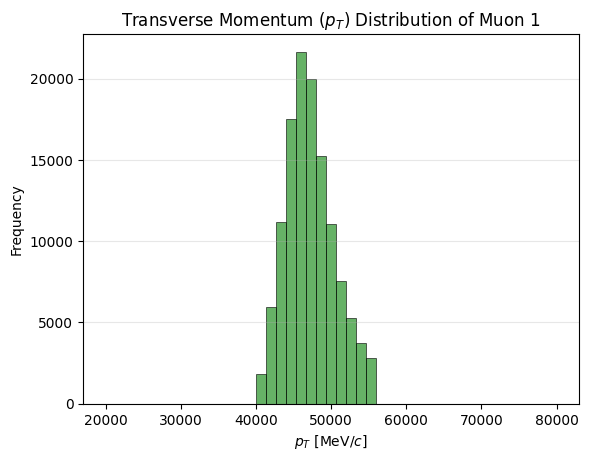

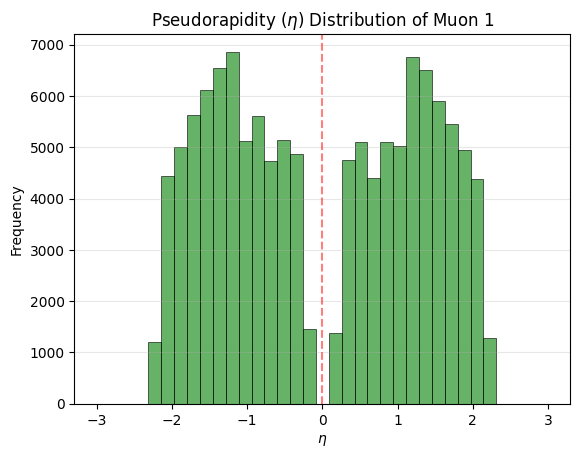

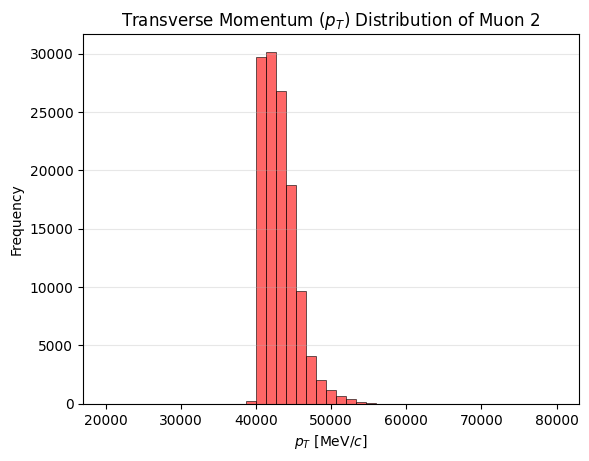

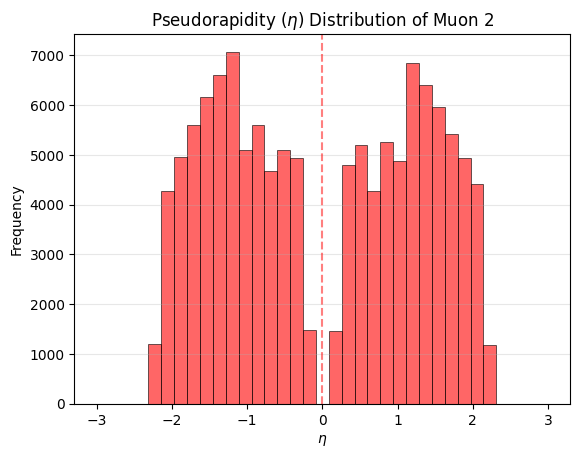

In [6]:

#################################################################

# let's make some simple histograms of the kineamtic information associated with the muons.
# as an example I look at muon[0] only, but you can look at muon[1] and compare the distributions.

# plot the mu[0] pt histogram.
plt.figure()
plt.title(r"Transverse Momentum ($p_T$) Distribution of Muon 1")
plt.xlabel(r"$p_T$ [MeV/$c$]")
plt.ylabel("Frequency")
plt.grid(axis='y', alpha=0.3)
plt.hist(lvArray0.pt, bins=45, edgecolor= "black",range=[20000,80000], linewidth = 0.7, alpha=0.6, color='g')
         
#plot the mu[0] pseudorapdity histogram.
plt.figure()
plt.title(r"Pseudorapidity ($\eta$) Distribution of Muon 1")
plt.xlabel(r"$\eta$")
plt.ylabel("Frequency")
plt.axvline(0, color='red', linestyle='--', alpha=0.5, label='Central (η=0)')
plt.grid(axis='y', alpha=0.3)
plt.hist(lvArray0.eta, bins=35, edgecolor= "black", range=[-3.0,3.0],linewidth = 0.7, alpha=0.6, color='g')
         

#################################################################


# plot the mu[1] pt histogram.
plt.figure()
plt.title(r"Transverse Momentum ($p_T$) Distribution of Muon 2")
plt.xlabel(r"$p_T$ [MeV/$c$]")
plt.ylabel("Frequency")
plt.grid(axis='y', alpha=0.3)
plt.hist(lvArray1.pt, bins=45, edgecolor= "black",range=[20000,80000], linewidth = 0.7, alpha=0.6, color='r')
         
#plot the mu[1] pseudorapdity histogram.
plt.figure()
plt.title(r"Pseudorapidity ($\eta$) Distribution of Muon 2")
plt.xlabel(r"$\eta$")
plt.ylabel("Frequency")
plt.axvline(0, color='red', linestyle='--', alpha=0.5, label='Central (η=0)')
plt.grid(axis='y', alpha=0.3)
plt.hist(lvArray1.eta, bins=35, edgecolor= "black", range=[-3.0,3.0],linewidth = 0.7, alpha=0.6, color='r')
         




# Step 5. Make histogram plots of the kinematic information of the muons.
- now that we have reconstructed four-vectors of the dimuon system and know how to make histogram plots,let's make a histogram plot of the dimuon mass distribution and see if the Cauchy distribution can be seen and if the peak is somehwhere around 90 GeV

- we will compare this histogram to a cauchy pdf. However, pdfs are always normalised to an area of 1 while our data represents hundreds of thousands of events, so the data histogram will surely have an integral much larger than 1. Therefore we must first calculate this integral use it to scale our pdf to allow a fair visual comparison between the data histogram and the predicted Cauchy distribution.

In [7]:
#we set up a few parmaters for our histogram, min and max of the x-axis (mass)
minMass = 71000
maxMass = 110000

#the number of bins
nBins = 250 

# creating the histogram as two arrays (bin edges & counts in the bins) numpy
countsData, edges = np.histogram(lvArray.mass, bins=nBins, range=(minMass, maxMass))

# get the width of each bin
bin_width = edges[1] - edges[0]
# sum over number in each bin and multiply by bin width, which can be factored out.
# This gives us the integral
integral = bin_width * sum(countsData[0:nBins])

# we can make an array of the centre of each bin directly from the edges array this will be useful in plotting our pdf
centres = (edges[1:] + edges[:-1]) / 2

#fit a Cauchy distributions to the dimuon mass data
mu, std = cauchy.fit(lvArray.mass)
print("mu = " + str(mu))   # best fit values
print("std = " + str(std))  # best fit values

mu = 91326.85565316534
std = 1834.3761308021221


So we are almost ready to compare our data histogram with the predicted Cauchy distribution but we know the Cauchy pdf has two free parameters: the mean (mu) and standard deviation (sigma). what should we choose for these values for a first comparison? Why not the world-average values published by the Particle Data group below...

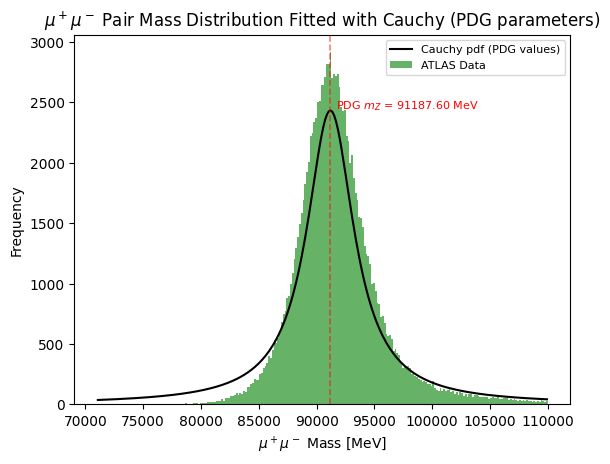


Fit results:
- Best fit mass = 91326.86 MeV
- Best fit width = 1834.38 MeV


In [8]:
mZPDG  = 91187.6
sigmaZPDG = 2495.2

#let's make the comparison plot USING PDG VALUES
plt.figure()
p = (cauchy.pdf(centres, mZPDG, sigmaZPDG) * integral)
plt.title(r"$\mu^+\mu^-$ Pair Mass Distribution Fitted with Cauchy (PDG parameters)")
plt.plot(centres, p, 'k',label="Cauchy pdf (PDG values)", linewidth=1.5)
plt.hist(lvArray.mass, bins=nBins, range=[minMass, maxMass],label="ATLAS Data", alpha=0.6, color='g')
plt.legend(loc='upper right', frameon=True, fontsize=8,  framealpha=0.8)

plt.xlabel(r"$\mu^+\mu^-$ Mass [MeV]")
plt.ylabel("Frequency")

# Add PDG value annotation
plt.axvline(mZPDG, color='red', linestyle='--', alpha=0.5, linewidth=1.2)
plt.text(mZPDG+500, 0.8*plt.ylim()[1], 
         rf"PDG $m_Z$ = {mZPDG/1:.2f} MeV", 
         color='red', ha='left', fontsize=8)
plt.show()

################################################
# USING BEST FIT VALUES
print(f"\nFit results:")
print(f"- Best fit mass = {mu:.2f} MeV")
print(f"- Best fit width = {std:.2f} MeV")
mZPDG  = mu
sigmaZPDG = std
#plt.figure()
p = (cauchy.pdf(centres, mZPDG, sigmaZPDG) * integral)
#plt.title(r"$\mu^+\mu^-$ Pair Mass Distribution Fitted with Cauchy (Best-fit parameters)")
#plt.plot(centres, p, 'k',label="Cauchy pdf (Best Fit Values)", linewidth=1.5)
#plt.hist(lvArray.mass, bins=nBins, range=[minMass, maxMass],label="ATLAS Data", alpha=0.6, color='g')
#plt.legend(loc='upper right', frameon=True, fontsize=8,  framealpha=0.8)

#plt.xlabel(r"$\mu^+\mu^-$ Mass [MeV]")
#plt.ylabel("Frequency")

# Add Best fit value annotation
#plt.axvline(mu, color='red', linestyle='--', alpha=0.5, linewidth=1.2)
#plt.text(mu+500, 0.8*plt.ylim()[1], 
         #rf" Best Fit $m_Z$ = {mu/1:.2f} MeV", 
         #color='red', ha='left', fontsize=8)
#plt.show()


The plot above shows a clear peak and a shape that looks very much like a Cauchy distrubtion. So we can be confident that our data conatains the decays of a heavy particle to pairs of muons. However the data does not perfectly agree with the predicted shape of Cauchy distributions with the PDG values for the mass and width of the Z boson.



# 6. Fitting the Cauchy model to the data
In the next part of this notebook we will try to assess if we can find values of the Z mass which result in a better 'agreement' between the data and Cauchy model. If we trust the Cauchy model completely, then this proceedure is a measurement of the Z mass. We'll define the agreement between our data and model with the chi-squared function. The function takes in arrays of event counts ('obs') and predictions ('preds') corresponding to the bins of the dimuon mass distribution. The function returns the squared difference between the event count and prediction divided by the variance on the prediction, summed over all bins, otherwise known as the chi-squared function.

In [9]:
#chi-squared function
def calcChiSq(obs, preds):
    chiSq = 0.0
    ndf = len(obs)
    for bin in range(0, len(obs)):
        diff = preds[bin] - obs[bin]
        var = ( np.abs(preds[bin])) # pearson's chi2 (approximate the prediction's variance as poisson, i.e., take the prediction as the variance)
        if (var != 0):
            chiSq += (diff**2)/(var)
    return chiSq, ndf

To perform the fit we will:
- We'll now loop over a range of $m_{Z}$ values, 
- Generate a cauchy distribution for each value and evaluate the $\chi^{2}$ between that distribution and the data histogram.
- find the $m_{Z}$ value that gives the smallest value of the $\chi^{2}$
- plot the $\Delta \chi^{2}$ vs the $m_{Z}$, and use the $\emph{critical values}$ of this curve to evaluate the uncertainties on $m_{Z}$
- compare the data histogram to the fitted Cauchy distribution

<Figure size 640x480 with 0 Axes>

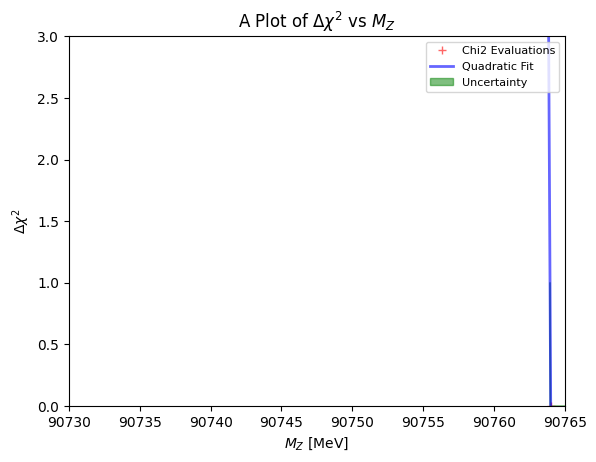

best-fit = 90764 +/- 0.04833097914524842


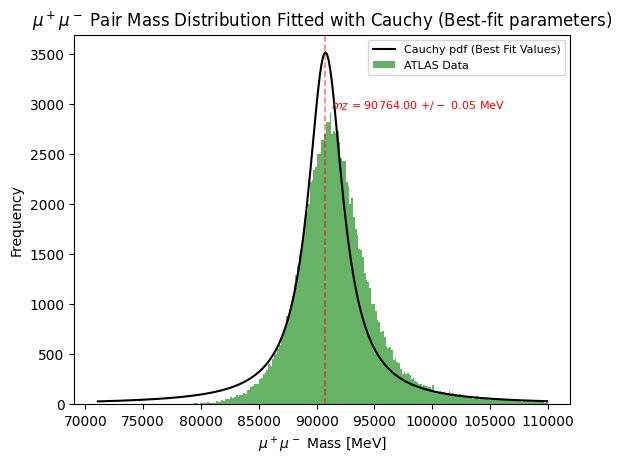

In [10]:
#some arrays to hold the z mass and chi-squared values
mZAr = np.array([])
chi2Ar = np.array([])

#deciding the range of z mass values and how fine the steps in this range will be
minMz = 90730
maxMz = 90765
step = 1

#vairables to use in the loop to find value of z mass that gives smallest chi2
bestFitMz1D = 0.0
minChi2 = 10000000

for mZ in range(minMz, maxMz, step): #starting loop
    countsPDF = (cauchy.pdf(centres, mZ, sigmaZPDG) * integral) #building pdf for these values
    #countsPDF = (norm.pdf(centres, mZ, sigmaZPDG) * integral) #building pdf for these values
    chi2, ndf = calcChiSq(countsData, countsPDF) # call chi2 function to get chi2 for this particular pdf and data
    mZAr = np.append(mZAr, mZ) #adding values to arrays
    chi2Ar = np.append(chi2Ar, chi2)
    if(chi2 < minChi2): #keeping track of what is the smallest chi2 value we have found
        minChi2 = chi2
        bestFitMz1D = mZ
                
# as we will only be interested in the change in chi2 w.r.t. mZ,  we can rescale all the chi2
#values such that the minimum chi2 value is 0. 
chi2Ar = chi2Ar - minChi2

#we expect the chi2 vs. mZ curve to be quadratic, so let's fit that fucntion to it.
z = np.polyfit(mZAr, chi2Ar, 2) #"2" for a second-order polynomial
p = np.poly1d(z)

#lets plot our chi2 values vs mz along with the fit
plt.figure()
fig, ax = plt.subplots()
ax.plot(mZAr, chi2Ar, 'r+', lw=5, alpha=0.6, label="Chi2 Evaluations")
ax.plot(mZAr, p(mZAr), 'b-', lw=2, alpha=0.6, label="Quadratic Fit")

# we can display the estimated uncertianty on mZ via critical values () of the delta chi-squared curve
y0 = 1.0
crit = (p - y0).roots # roots of the polynominal -1, i.e., the mz values where p = 1 

#shading in the uncertainty band 
px=np.arange(crit[1],crit[0],0.001)
ax.fill_between(px,p(px),alpha=0.5, color='g', label="Uncertainty")
ax.legend(loc='upper right', frameon=True, fontsize=8,  framealpha=0.8)
#setting reasonable axis ranges and titles
plt.title(r"A Plot of $\Delta\chi^2$ vs $M_{Z}$")
ax.set_xlim(minMz, maxMz)
ax.set_ylim(0.0, 3)
plt.xlabel(r"$M_{Z}$ [MeV]")
plt.ylabel(r"$\Delta\chi^2$")
plt.legend(loc='upper right', frameon=True, fontsize=8,  framealpha=0.8)

plt.show()

#print result and uncertainty
my1DResult = bestFitMz1D
my1DUncertainty = bestFitMz1D-crit[1]
print("best-fit = " + str(my1DResult) + " +/- " + str(my1DUncertainty))

# we now compare our data histogram with the cauchy distribution with the mean and standard deviation
# that minimise the chi-squared. This pdf should agree much better than the pdf with the PDG values.

plt.figure()
p = (cauchy.pdf(centres, my1DResult, sigmaZPDG))

pInt = bin_width * sum(p[0:nBins])
scale = integral/pInt
pScaled = (cauchy.pdf(centres, my1DResult, sigmaZPDG) *scale)

plt.plot(centres, pScaled, 'k', linewidth=1.5,label="Cauchy pdf (Best Fit Values)")

x = np.linspace(87000, 94000, 1000)
pScaledNorm = (norm.pdf(x, my1DResult, (sigmaZPDG*0.8) )*(0.6*scale))

#plt.plot(x, pScaledNorm, 'r', linewidth=2)
plt.title(r"$\mu^+\mu^-$ Pair Mass Distribution Fitted with Cauchy (Best-fit parameters)")
plt.hist(lvArray.mass, bins=nBins, range=[minMass, maxMass], alpha=0.6, color='g',label="ATLAS Data")

plt.legend(loc='upper right', frameon=True, fontsize=8,  framealpha=0.8)

plt.xlabel(r"$\mu^+\mu^-$ Mass [MeV]")
plt.ylabel("Frequency")
plt.axvline(my1DResult, color='red', linestyle='--', alpha=0.5, linewidth=1.2)
plt.text(my1DResult+500, 0.8*plt.ylim()[1], 
         rf"$m_Z$ = {my1DResult:.2f} $+/-$ {my1DUncertainty:.2f} MeV", 
         color='red', ha='left', fontsize=8)
plt.show() 





#############################################################


# Try a double gaussian with curve_fit

Text(0, 0.5, 'Data')

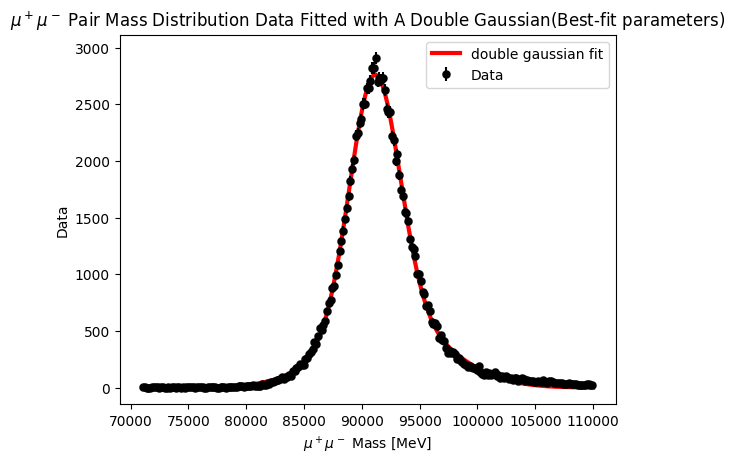

In [11]:
from scipy.optimize import curve_fit

def gaussian(x, mean, amplitude, standard_deviation):
    return amplitude * np.exp( - ((x - mean) / standard_deviation) ** 2)

def doubleGaussian(x, mean1, amplitude1, standard_deviation1, mean2, amplitude2, standard_deviation2):
    gaus1 = amplitude1 * np.exp( - ((x - mean1) / standard_deviation1) ** 2)
    gaus2 = amplitude2 * np.exp( - ((x - mean2) / standard_deviation2) ** 2)
    return gaus1 + gaus2

#bestFitParams, covarianceMatrix = curve_fit(gaussian, centres, countsData, p0=[91000., 2000., 10000.])
bestFitParams, covarianceMatrix = curve_fit(doubleGaussian, centres, countsData, p0=[91000., 2000., 10000., 91000, 6000, 2000])

x_interval_for_fit = np.linspace(edges[0], edges[-1], 10000)
#plt.plot(x_interval_for_fit, gaussian(x_interval_for_fit, *bestFitParams), label='gaussian fit')
plt.title(r"$\mu^+\mu^-$ Pair Mass Distribution Data Fitted with A Double Gaussian(Best-fit parameters)")
plt.plot(x_interval_for_fit, doubleGaussian(x_interval_for_fit, *bestFitParams),'r-', linewidth=3, label='double gaussian fit')
plt.errorbar(centres, countsData, yerr=np.sqrt(countsData), label="Data", fmt='o', mfc='k', mec='k', mew=0.1, ecolor='k')
plt.legend()
plt.xlabel(r"$\mu^+\mu^-$ Mass [MeV]")
plt.ylabel("Data")

now we have a 'measurement' of mZ, let's make a plot comparing our measured value with that from
the PDG to assess how good our measurement is.

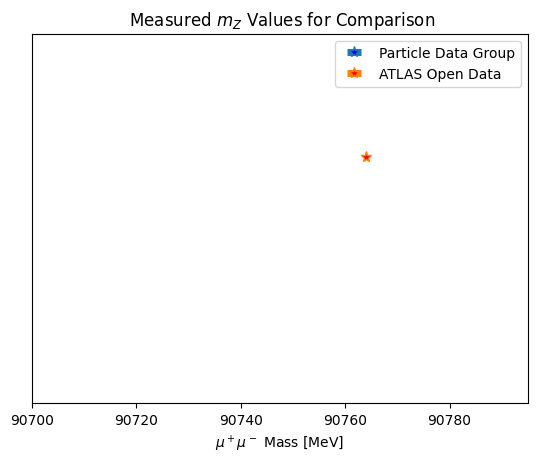

In [12]:
mZPDGAr = np.array([mZPDG]) 
uncZPDG = 2.1 #MeV
uncZPDGAr = np.array([uncZPDG]) # https://pdg.lbl.gov/2018/listings/rpp2018-list-z-boson.pdf
yPDGAr = np.array([1.0]) 

mZ1D = np.array([my1DResult]) 
sigZ1D = np.array([my1DUncertainty]) 
y1D = np.array([2.0]) 

plt.figure()
ax = plt.gca()
ax.set_xlim(minMz-30, maxMz+30)#need to extend x axis range to include PDG value
ax.set_ylim(0.0, 3.0)
plt.title(r" Measured $m_Z$ Values for Comparison")

plt.errorbar(mZPDGAr, yPDGAr, xerr=uncZPDGAr, label="Particle Data Group", elinewidth=5,  fmt="*", mfc="blue", ms=8)
plt.errorbar(mZ1D, y1D, xerr=sigZ1D, fmt="*", label="ATLAS Open Data", elinewidth=5, ms=8, mfc='red')

plt.xlabel(r"$\mu^+\mu^-$ Mass [MeV]")
plt.yticks(y1D, " ")

ax.axes.yaxis.set_visible(False)
plt.legend()
plt.show()

Thats completes steps 1-5. You have seen how the chi-squared minimisation technique allows us to extract measurements
of a physical parameter such as $m_{Z}$ by comparing the predictions of statistical model to data.

# Now it's your turn!

Refer back to the lab manual to see how you might improve this measurement and have fun!

In [13]:
# Your explorations go here!

# Optional extra activity

The previous activities complete the lab and you should receive a great grade if you complete them all, add your own investigations on modifications of the analysis and their interpretation as well as writing up a report that is clear and detailed.

However, I wanted to show you some more advanced and systematics explorations of the data and analysis that will demonstrate the ways particle physicists interrogate their own results to check for potential systematic biases and sources of uncertainty that may not be immediatley apparent. You will have likely obtained a result for the Z mass that does not agree with the PDG value. This is not neccessarily a problem: we can never fully rule out the possibility that the PDG value is wrong and your result is correct. Even if there was agreement between the two values, we would still want to check for systematic uncertainties in our analysis. One way this could show up is a string dependence of our results on the 'parameters' of our analysis, e.g, the cuts we apply to the data or the particular fit model. Small changes to these parameters should not grealty affect our results unless there are some systematic biases at play. Hence we should estimate how much our result depends on these parameters and calculate an extra, "systematic" uncetainty for our result.

A rigorous way to do this is to systematically scan over multiple options for our analysis parameters, extra results for each option and finally plot the results as a function of the parameters.

To do this, we will have to advance our coding a little, such that it is easy to automatically run our full analysis with any set of analysis parameters. Practically, we write the entire analysis that "measures" the Z mass into a single python function that takes the analysis parmeters as inputs an returns the measure Z mass and standard devaiation. We then plot the results as a function of the parameter choices. Note that for simplicity and speed, I replaced our more precise chi-squared fit with a simpler, least-squares fit from curve fit. This is not sufficiently precise to calculate our final result of statistical uncertainty, but is good enough to check for the systematic biases mentioned.

# Move on to Part 2 of this lab before attempting this optional extra activity!



In [14]:
# the z mass analysis as one function
def measure_z_mass(data_df, cut_values, pdf_name):
    # Apply event selections based on the provided cut values
    cuts = data_df.copy()
    cuts = cuts[cuts['muon_charge'].apply(lambda x: x[0] + x[1] == 0)]
    cuts = cuts[(cuts["muon_pt"]).apply(lambda x: x[0] > cut_values['pt_cut']) & (cuts["muon_pt"]).apply(lambda x: x[1] > cut_values['pt_cut'])]
    cuts = cuts[(cuts["muon_eta"]).apply(lambda x: np.abs(x[0]) < cut_values['eta_cut']) & (cuts["muon_eta"]).apply(lambda x: np.abs(x[0]) < cut_values['eta_cut'])]
    
    # Apply isolation criteria if provided
    if 'iso_et_cut' in cut_values:
        cuts['iso_et20_mu0'] = (pd.Series(cuts['muon_etcone20']).apply(lambda x: x[0]) / pd.Series(cuts['muon_pt']).apply(lambda x: x[0]))
        cuts['iso_et20_mu1'] = (pd.Series(cuts['muon_etcone20']).apply(lambda x: x[1]) / pd.Series(cuts['muon_pt']).apply(lambda x: x[1]))
        cuts = cuts[(cuts['iso_et20_mu0'] < cut_values['iso_et_cut']) & (cuts['iso_et20_mu1'] < cut_values['iso_et_cut'])]
    
    # Reconstruct the Z boson
    pt0 = cuts['muon_pt'].apply(lambda x: x[0]).to_numpy()
    eta0 = cuts['muon_eta'].apply(lambda x: x[0]).to_numpy()
    phi0 = cuts['muon_phi'].apply(lambda x: x[0]).to_numpy()
    E0 = cuts['muon_E'].apply(lambda x: x[0]).to_numpy()
    
    pt1 = cuts['muon_pt'].apply(lambda x: x[1]).to_numpy()
    eta1 = cuts['muon_eta'].apply(lambda x: x[1]).to_numpy()
    phi1 = cuts['muon_phi'].apply(lambda x: x[1]).to_numpy()
    E1 = cuts['muon_E'].apply(lambda x: x[1]).to_numpy()
    
    lvArray0 = vector.array({"pt": pt0, "phi": phi0, "eta": eta0, "E": E0})
    lvArray1 = vector.array({"pt": pt1, "phi": phi1, "eta": eta1, "E": E1})
    lvArray = lvArray0 + lvArray1
    
    # Create a histogram of the dimuon mass distribution
    min_mass, max_mass = 70000, 110000
    n_bins = 100
    counts, edges = np.histogram(lvArray.mass, bins=n_bins, range=(min_mass, max_mass))
    bin_centers = (edges[1:] + edges[:-1]) / 2
    bin_width = edges[1] - edges[0]
    
    # Calculate the sum of bin counts
    sum_counts = np.sum(counts)
    
    # Define the fit function based on the provided PDF name
    if pdf_name == 'cauchy':
        def fit_func(x, loc, scale, intgrl):
            pdf = cauchy.pdf(x, loc, scale)
            return intgrl * pdf / np.sum(pdf) * sum_counts
    elif pdf_name == 'gaussian':
        def fit_func(x, mean, std, intgrl):
            pdf = norm.pdf(x, mean, std)
            return intgrl * pdf / np.sum(pdf) * sum_counts
    else:
        raise ValueError(f"Unsupported PDF: {pdf_name}")
    
    # Perform the fit with initial parameter guesses
    p0 = [91000, 2000, 1.0]  # Initial guesses for mean, std, and norm
    params, p_cov = curve_fit(fit_func, bin_centers, counts, p0=p0)
    
    # Extract the fitted Z mass, uncertainty, and scaling factor
    if pdf_name == 'cauchy':
        z_mass = params[0]
        z_mass_sigma = params[1]
        scaling_factor = params[2]
    elif pdf_name == 'gaussian':
        z_mass = params[0]
        z_mass_sigma = params[1]
        scaling_factor = params[2]
    
    # Calculate the chi-squared value and degrees of freedom
    fit_counts = fit_func(bin_centers, *params)
    chi_squared = np.sum((counts - fit_counts)**2 / fit_counts)
    dof = n_bins - len(params)
    
    
    # Return all the necessary details
    return {
        'z_mass': z_mass,
        'z_mass_sigma': z_mass_sigma,
        'scaling_factor': scaling_factor,
        'bin_centers': bin_centers,
        'bin_width': bin_width,
        'counts': counts,
        'fit_counts': fit_counts,
        'chi_squared': chi_squared,
        'dof': dof
    }

# Define a range of cut values and PDFs to test

#these first set of options will take quite some time to run
#pt_cuts = [20000, 25000, 30000]
#eta_cuts = [2.0, 2.4, 2.8]
#iso_et_cuts = [0.1, 0.2, 0.3]
#pdfs = ['cauchy', 'gaussian']

# hence first test with this shorter set (takes around 5 minutes to run)
# Define a range of cut values and PDFs to test
pt_cuts = [20000, 40000]
eta_cuts = [1.5, 2.4]
iso_et_cuts = [0.1, 0.5]
pdfs = ['cauchy','gaussian']

results = []

for pt_cut in pt_cuts:
    for eta_cut in eta_cuts:
        for iso_et_cut in iso_et_cuts:
            for pdf in pdfs:
                cut_values = {'pt_cut': pt_cut, 'eta_cut': eta_cut, 'iso_et_cut': iso_et_cut}
                fit_results = measure_z_mass(df, cut_values, pdf)
                
                result = {
                    'pt_cut': pt_cut,
                    'eta_cut': eta_cut,
                    'iso_et_cut': iso_et_cut,
                    'pdf': pdf,
                    'z_mass': fit_results['z_mass'],
                    'z_mass_sigma': fit_results['z_mass_sigma'],
                    'bin_centers': fit_results['bin_centers'],
                    'bin_width': fit_results['bin_width'],
                    'counts': fit_results['counts'],
                    'fit_counts': fit_results['fit_counts'],
                    'scaling_factor': fit_results['scaling_factor'],
                    'chi_squared': fit_results['chi_squared'],
                    'dof': fit_results['dof']
                }
                
                results.append(result)

results_df = pd.DataFrame(results)
print(results_df)


Now let's plot the results to check for systematic biases

In [15]:
# Convert the results to a DataFrame for easier plotting
results_df = pd.DataFrame(results)
print(results_df)

min_mass, max_mass = 70000, 110000
n_bins = 100

# Create a grid of subplots for each combination of parameters
fig, axes = plt.subplots(len(eta_cuts), len(iso_et_cuts), figsize=(12, 10), sharex=True, sharey=True)

for i, eta_cut in enumerate(eta_cuts):  # this code will only work if you scan over multiple eta values
    for j, iso_et_cut in enumerate(iso_et_cuts):
        ax = axes[i, j]
        
        for pdf in pdfs:
            data = results_df[(results_df['eta_cut'] == eta_cut) & (results_df['iso_et_cut'] == iso_et_cut) & (results_df['pdf'] == pdf)]
            
            ax.errorbar(data['pt_cut'], data['z_mass'], yerr=data['z_mass_sigma'], fmt='-o', label=pdf)
        
        # Add a horizontal semi-transparent dashed line for the "true" Z mass value
        ax.axhline(y=mZPDG, color='gray', linestyle='--', alpha=0.5)
        
        # Add a semi-transparent band indicating the uncertainty on the PDG values
        ax.axhspan(mZPDG - uncZPDG, mZPDG + uncZPDG, color='gray', alpha=0.2, label=r'$m_{Z}$ PDG')
        
        ax.set_title(f'eta_cut = {eta_cut}, iso_et_cut = {iso_et_cut}')
        ax.set_xlabel('pt_cut')
        ax.set_ylabel('Fitted Z Mass')
        ax.legend()

plt.tight_layout()
plt.show()

# Create a new figure with the fit results for each combination of parameters
fig2, axes2 = plt.subplots(len(eta_cuts), len(iso_et_cuts), figsize=(12, 10), sharex=True, sharey=True)

for i, eta_cut in enumerate(eta_cuts):
    for j, iso_et_cut in enumerate(iso_et_cuts):
        ax2 = axes2[i, j]
        
        for pdf in pdfs:
            data = results_df[(results_df['eta_cut'] == eta_cut) & (results_df['iso_et_cut'] == iso_et_cut) & (results_df['pdf'] == pdf)]
            
            for _, row in data.iterrows():
                pt_cut = row['pt_cut']
                pdf_name = row['pdf']
                z_mass = row['z_mass']
                z_mass_sigma = row['z_mass_sigma']
                bin_centers = row['bin_centers']
                bin_width = row['bin_width']
                counts = row['counts']
                fit_counts = row['fit_counts']
                
                # Plot the dimuon mass distribution histogram and fitted function
                ax2.hist(bin_centers, bins=len(bin_centers), weights=counts, histtype='step', alpha=0.5, label=f'Data (pt_cut = {pt_cut}, pdf = {pdf_name})')
                ax2.plot(bin_centers, fit_counts, label=f'Fit (pt_cut = {pt_cut}, pdf = {pdf_name})')
        
        ax2.set_title(f'eta_cut = {eta_cut}, iso_et_cut = {iso_et_cut}')
        ax2.set_xlabel('Dimuon Mass [MeV]')
        ax2.set_ylabel('Events')
        ax2.legend()

plt.tight_layout()
plt.show()


NameError: name 'results' is not defined